In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
import os
import gc
import glob
#os.environ['QT_QPA_PLATFORM']='offscreen' #Necessaire pour utiliser ipython en interactif hors du CNRM, sinon erreur avec le Display
import sys
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import xarray as xr
import xesmf as xe
import ssl 
import readnc_tools as rd
import readnc2_tools as rd2
import plot_tools as pt
ssl._create_default_https_context = ssl._create_unverified_context
pathin="/cnrm/pastel/USERS/ardilouzec/ncdf/S2S/"
pathobs="/cnrm/pastel/USERS/ardilouzec/obs/era5_land/"

#Subsample the list of forecast dates so as to take the last date of february and the 3 following ones for each year. !!!! SHOULD NOT BE APPLIED TO BOM (forecast date frequency higher than weekly) !!
def subsample_dates(list_dates):
    subsample=[]
    for y in range(1996,2014):
     d=[x for x in list_dates if x.month==2 and x.year==y][-1] #last February date of each year
     index=list_dates.index(d)
     subsample=subsample+list_dates[index:index+4]
    return subsample


def period(x):
    return {
      0:'Early spring',
      1:'Mid spring',
      2:'Late spring',
    }[x]
def observation(x):
    return {
      'ERA5 Land':obs1,
      'MERRA2':obs2,
      'JRA55':obs3,
    }[x]


<frozen importlib._bootstrap>:219: UserWarning: PROJ 8+ is required. Current version: 7.2.0


In [2]:
# In[2]:

ref1='era5land'
variables=['sd']
lat_lims = [30,90]
obs1=rd.read_ref(pathobs,variables,ref1)
obs1=obs1.sel(time=obs1.time.dt.month.isin([2, 3, 4])).sel(time=slice('1993-02-01','2018-04-30')).sel(lat=slice(30,90))*1000 #(*1000 for unit conversion)

ref2='merra2'
obs2=rd.read_ref(pathobs,variables,ref2)
obs2=obs2.sel(time=obs2.time.dt.month.isin([2, 3, 4])).sel(time=slice('1993-02-01','2018-04-30')).sel(lat=slice(30,90))


ref3='JRA55'
obs3=rd.read_ref(pathobs,variables,ref3)
obs3=obs3.sel(time=obs3.time.dt.month.isin([2, 3, 4])).sel(time=slice('1993-02-01','2018-04-30')).sel(lat=slice(30,90))

dimension=xr.DataArray(pd.Series(range(3),name='reference',index=['ERA5-LAND','MERRA2','JRA55']))

obs=xr.concat([obs1,obs2,obs3],dim=dimension).rename({'dim_0':'Ref'}).compute()

/home/ardilouzec/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/ardilouzec/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


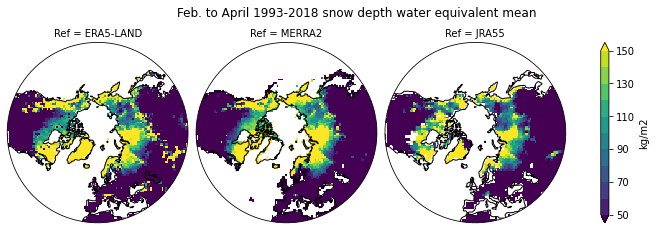

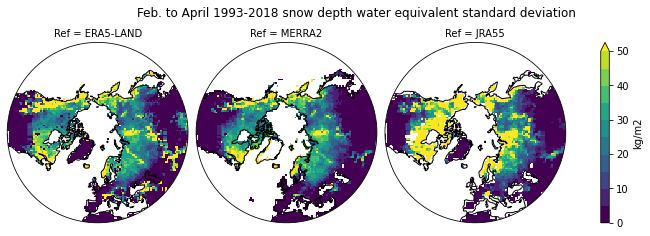

In [6]:
levels_mean= np.arange(50,160,10)

p=obs.sd.mean(dim='time').plot.imshow(x='lon',y='lat',col='Ref',cmap='viridis',robust=True, levels=levels_mean,transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
for i,ax in enumerate(p.axes.flat):
    pt.polarCentral_set_latlim(lat_lims,ax)
    ax.coastlines()
p.cbar.set_label(label='kg/m2')
p.fig.suptitle('Feb. to April 1993-2018 snow depth water equivalent mean',y=1.05)
plt.show()

levels_std = np.arange(0,55,5)
p=obs.sd.groupby("time.year").mean("time").std(dim='year').plot.imshow(x='lon',y='lat',col='Ref',cmap='viridis',robust=True, levels=levels_std,transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
for i,ax in enumerate(p.axes.flat):
    pt.polarCentral_set_latlim(lat_lims,ax)
    ax.coastlines()
p.cbar.set_label(label='kg/m2')
p.fig.suptitle('1993-2018 snow depth water equivalent interannual standard deviation (Feb. to April mean)',y=1.05)
plt.show()

In [7]:
# Hovmoller 

lat_slice = slice(40,60)
lon_slice = slice(0, 360)
obshov=obs.sd.sel(lat=lat_slice, lon=lon_slice)
weights = np.cos(np.deg2rad(obshov.lat.values))

month_day_str = xr.DataArray(obs.indexes['time'].strftime('%m-%d'),name='month_day_str')
obshov=obshov.groupby(month_day_str).mean('time')

avg_obshov = (obshov * weights[None, None, :, None]).sum(dim='lat') / np.sum(weights)
vtimes=obshov.month_day_str.values
lons=obshov.lon.values

['0°E', '90°E', '180°E', '90°W', '0°E']


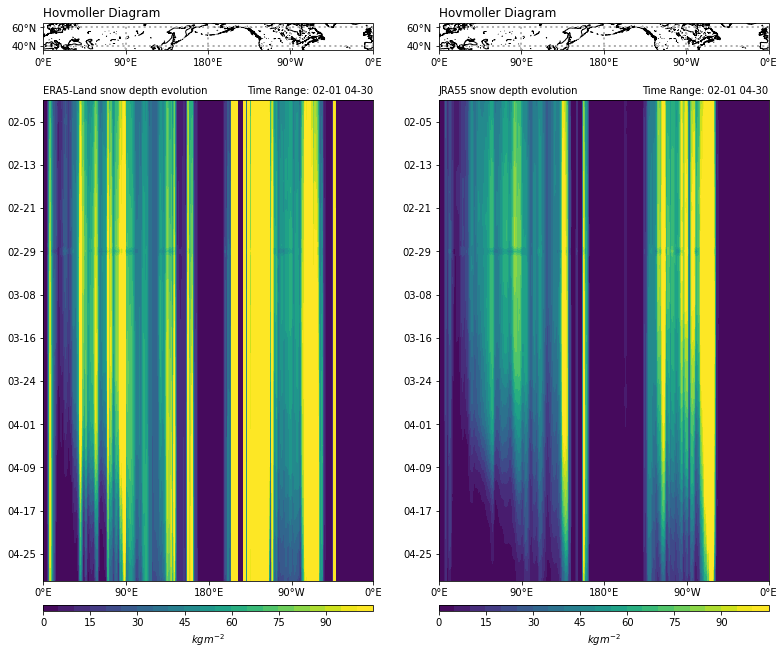

In [16]:
# Hovmoller (suite)
# Start figure
fig = plt.figure(figsize=(13, 13))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 6], hspace=0.04)
# Tick labels
x_tick_labels = [u'0\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'180\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}W', u'0\N{DEGREE SIGN}E']
print(x_tick_labels)
# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([0, 359, 35, 65], ccrs.PlateCarree(central_longitude=180))
ax1.set_yticks([40, 60])
ax1.set_yticklabels([u'40\N{DEGREE SIGN}N', u'60\N{DEGREE SIGN}N'])
ax1.set_xticks([-180, -90, 0, 90, 180])
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='dotted', linewidth=2)
# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.5)
# Set some titles
plt.title('Hovmoller Diagram', loc='left')


# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
# Plot of chosen variable averaged over latitude and slightly smoothed
clevs = np.arange(0, 101, 5)
#cf = ax2.contourf(lons, vtimes, mpcalc.smooth_n_point(avg_obshov[0,:,:], 9, 2), clevs, cmap='viridis', extend='max')
cf = ax2.contourf(lons, vtimes, avg_obshov[0,:,:], clevs, cmap='viridis', extend='max')

cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
cbar.set_label('$kg m^{-2}$')

# Make some ticks and tick labels
ax2.set_xticks([0., 90., 180, 270, 358.5])
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(vtimes[4::8])
ax2.set_yticklabels(vtimes[4::8])

# Set some titles
plt.title('ERA5-Land snow depth evolution', loc='left', fontsize=10)
plt.title('Time Range: '+vtimes[0] +' '+vtimes[-1],loc='right', fontsize=10)

ax3 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax3.set_extent([0, 359, 35, 65], ccrs.PlateCarree(central_longitude=180))
ax3.set_yticks([40, 60])
ax3.set_yticklabels([u'40\N{DEGREE SIGN}N', u'60\N{DEGREE SIGN}N'])
ax3.set_xticks([-180, -90, 0, 90, 180])
ax3.set_xticklabels(x_tick_labels)
ax3.grid(linestyle='dotted', linewidth=2)
# Add geopolitical boundaries for map reference
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax3.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.5)
# Set some titles
plt.title('Hovmoller Diagram', loc='left')

ax4 = fig.add_subplot(gs[1, 1])
ax4.invert_yaxis()  # Reverse the time order to do oldest first
# Plot of chosen variable averaged over latitude and slightly smoothed
clevs = np.arange(0, 101, 5)
#cf = ax2.contourf(lons, vtimes, mpcalc.smooth_n_point(avg_obshov[0,:,:], 9, 2), clevs, cmap='viridis', extend='max')
cf = ax4.contourf(lons, vtimes, avg_obshov[2,:,:], clevs, cmap='viridis', extend='max')

cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
cbar.set_label('$kg m^{-2}$')

# Make some ticks and tick labels
ax4.set_xticks([0., 90., 180, 270, 358.5])
ax4.set_xticklabels(x_tick_labels)
ax4.set_yticks(vtimes[4::8])
ax4.set_yticklabels(vtimes[4::8])

# Set some titles
plt.title('JRA55 snow depth evolution', loc='left', fontsize=10)
plt.title('Time Range: '+vtimes[0] +' '+vtimes[-1],loc='right', fontsize=10)
plt.show()

In [4]:
def plot_corr(mod,var,nyear,ini,threshold): #ini = 0 pour early spring, 1 pour MId Spring ou 2 pour Late spring
  fic=[ f for f in glob.glob(pathin+mod+'/*'+var+'_????????.nc') if (datetime.strptime(f[-11:-3],'%Y%m%d') in model(mod)) ]
  ds= xr.open_mfdataset(fic,preprocess = prepro)
  ds= ds.chunk({'member':1,'lon':60})
  ds=hind_anomaly(ds)
  ds.attrs['model']=mod
  a=ds.sel(init=ds.init[ini*4:ini*4+4])
  for y in range(1,nyear):
   a=xr.concat([a,ds.sel(init=ds.init[4*y+ini*4:4*y+ini*4+4])],dim='init')
  ds=a
  ds.attrs['model']=mod
  hin=HindcastEnsemble(ds.chunk({'init':-1,'member':-1,}))
  for ref in ['ERA5 Land','MERRA2','JRA55']:
   obs=observation(ref)
   hins2s=hin.add_observations(obs.chunk({'time':-1})).compute()
   a=hins2s.smooth(dict(lead=7), how="mean").verify(metric="pearson_r",comparison="e2o",alignment="same_inits",dim=["init"]).sel(lead=["4-10","11-17","18-24","25-31"])
   pval=hins2s.smooth(dict(lead=7), how="mean").verify(metric="pearson_r_eff_p_value",comparison="e2o",alignment="same_inits",dim=["init"]).sel(lead=["4-10","11-17","18-24","25-31"])
   #p=a.to_array()[0,:,:,:].plot(x='lon',y='lat',col='lead',col_wrap=3,cmap='viridis',robust=True,levels=levels, transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
   plt.rcParams.update({'axes.titlesize': 'small'})
   p=a.to_array()[0,:,:,:].plot.imshow(x='lon',y='lat',col='lead',cmap='viridis',robust=True,levels=levels, transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
   for i,ax in enumerate(p.axes.flat):
     #b=a.to_array()[0,i,:,:]<0.4
     b=a.where(pval>threshold)
     b.to_array()[0,i,:,:].plot.contourf('lon','lat',ax=ax,colors='None',add_colorbar=False,levels=3,hatches=['',4*'/'],transform=ccrs.PlateCarree(),alpha=0.10)
     pt.polarCentral_set_latlim(lat_lims,ax)
     ax.coastlines()
     ax.set_title('lead='+str(a.lead[i].values))
   p.fig.suptitle(mod+' '+period(ini)+' '+'ref: '+ref,y=1.05)
   plt.show()
   del a, b, p, hins2s, obs
   gc.collect()
  del ds, hin
  gc.collect()

In [5]:
for var in variables:
 #for mod in ['HMCR','CNRM','BOM','ECMWF']: 
 #for mod in ['BOM']: 
    plot_corr('CNRM',var,18,0,0.05)
    plot_corr('BOM',var,18,0,0.05)
    plot_corr('HMCR',var,18,0,0.05)
    plot_corr('ECMWF',var,18,0,0.05)


MemoryError: Unable to allocate 2.90 GiB for an array with shape (120, 1801, 3600) and data type float32